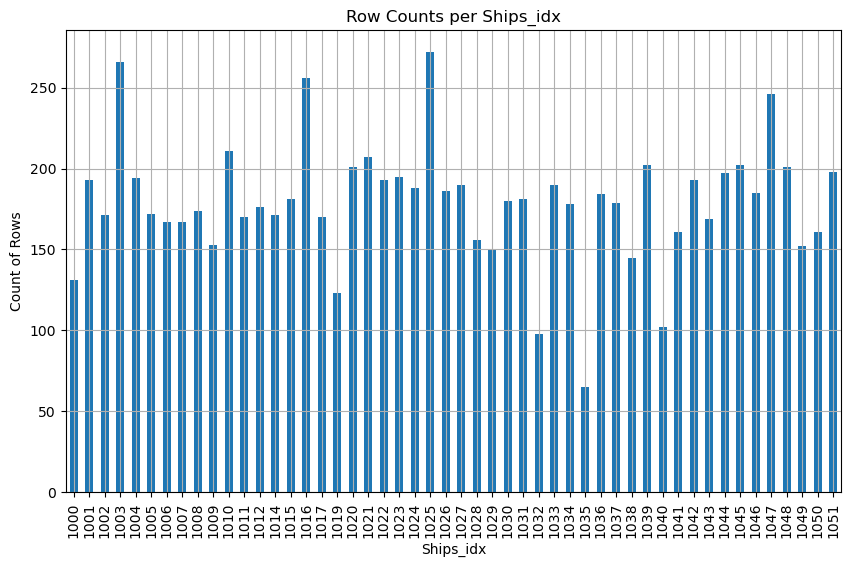

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

data_path = f"../select_db/data_mapping_filtered.csv"
# Ensure to include 'ships_idx' in the fields list
fields = ['ships_idx', 'tag_name', 'tag_description', 'thing', 'property']

# Load the dataset
try:
    df = pd.read_csv(data_path, skipinitialspace=True, usecols=fields)
except UnicodeDecodeError:
    df = pd.read_csv(data_path, skipinitialspace=True, usecols=fields, encoding='ISO-8859-1')

# Group the data by 'ships_idx' and count the rows for each group
row_counts = df.groupby('ships_idx').size()

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the size of the figure as needed
row_counts.plot(kind='bar')  # You can also use 'barh' for a horizontal bar plot
plt.title('Row Counts per Ships_idx')
plt.xlabel('Ships_idx')
plt.ylabel('Count of Rows')
plt.grid(True)
plt.show()


In [22]:
from sklearn.model_selection import train_test_split
import pandas as pd
import json

# Assuming df is your DataFrame loaded with necessary data
unique_ships_idx = df['ships_idx'].unique()

# First, split the ships_idx for training (80%) and temporary test (20%)
train_idx, temp_test_idx = train_test_split(unique_ships_idx, test_size=0.2, random_state=42)

# Next, split the temporary test idx into actual test and validation, each 10% of the total, thus 50-50 of the temp test
test_idx, validation_idx = train_test_split(temp_test_idx, test_size=0.5, random_state=42)

# Print the ships_idx for training, testing, and validation
print("Training ships_idx:", train_idx)
print("Testing ships_idx:", test_idx)
print("Validation ships_idx:", validation_idx)

# Filter the DataFrame based on the split indices
train_df = df[df['ships_idx'].isin(train_idx)]
test_df = df[df['ships_idx'].isin(test_idx)]
validation_df = df[df['ships_idx'].isin(validation_idx)]

# Print the total number of rows in training, testing, and validation datasets
print("Total rows in training dataset:", len(train_df))
print("Total rows in testing dataset:", len(test_df))
print("Total rows in validation dataset:", len(validation_df))

# Function to convert DataFrame to JSON format
def df_to_json(df, filename):
    output_list = [{
        'translation': {
            'ships_idx': row['ships_idx'],
            'tag_description': row['tag_description'],
            'thing_property': f"{row['thing']}@{row['property']}"
        }
    } for _, row in df.iterrows()]

    with open(filename, 'w') as json_file:
        json.dump(output_list, json_file, indent=4)

# Create JSON files
df_to_json(train_df, 'data_tp_train.json')
df_to_json(test_df, 'data_tp_test.json')
df_to_json(validation_df, 'data_tp_validation.json')


Training ships_idx: [1039 1036 1032 1010 1014 1008 1033 1047 1049 1015 1011 1005 1029 1028
 1023 1000 1046 1050 1001 1019 1038 1037 1025 1026 1006 1027 1003 1024
 1035 1051 1017 1007 1016 1030 1012 1004 1043 1040 1045 1002]
Testing ships_idx: [1021 1041 1020 1048 1034]
Validation ships_idx: [1022 1031 1009 1044 1042]
Total rows in training dataset: 7088
Total rows in testing dataset: 948
Total rows in validation dataset: 917
